<H2>Intoduction</H2>

<p>Link to the Kaggle competition: https://www.kaggle.com/c/noaa-right-whale-recognition
The training data can be found at the above link.</p>

<p>The objective is to identify the North Atlantic Right whales from aerial photographs through machine learning. This is required to keep track of this endangered species and support conservation efforts. Experienced marine biologists can identify these whales by sight but new hires have to flip all previous images of the whales and compare them with the whale that has been sighted.</p>

<p>How to identify a Right whale?</p>

<p>Each Right whale has a unique callosity pattern on the head. Callosities are hardened skin that appears white.</p>

<p>http://www.neaq.org/education_and_activities/games_and_activities/online_games/right_whale_identification_games.php
The above is an interactive game that teaches how to identify Right whales.</p>

<p>References: 
<ul><li>http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/#second-model-convolutions
<li>http://nbviewer.ipython.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb
<li>http://ufldl.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/
<li>http://www.explainthatstuff.com/introduction-to-neural-networks.html
</ul></p>

<h2> <b> What is a neural network? </b> </h2>



The basic idea behind a neural network is to simulate lots of densely interconnected brain cells inside a computer so you can get it to learn things, recognize patterns, and make decisions in a humanlike way. It follows the one learning algorithm theory.

<b> What does a neural network consist of? </b>

<br> 1) A typical neural network has anything from a few dozen to hundreds, thousands, or even millions of artificial neurons called units arranged in a series of layers, each of which connects to the layers on either side. Some of them, known as <b> input units </b> , are designed to receive various forms of information from the outside world that the network will attempt to learn about, recognize, or otherwise process.</br>


2) Other units sit on the opposite side of the network and signal how it responds to the information it's learned; those are known as <b> output units </b> </br>

3) In between the input units and output units are one or more layers of <b> hidden units </b>, which, together, form the majority of the artificial brain. Most neural networks are fully connected, which means each hidden unit and each output unit is connected to every unit in the layers either side. The connections between one unit and another are represented by a number called a <b> weight </b> , which can be either positive (if one unit excites another) or negative (if one unit suppresses or inhibits another). The higher the weight, the more influence one unit has on another. (This corresponds to the way actual brain cells trigger one another across tiny gaps called synapses.






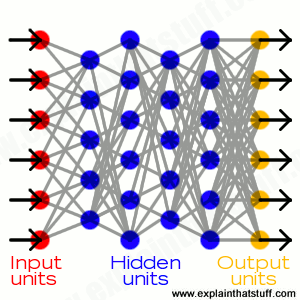

In [13]:
import os
from IPython.display import Image
Image(filename=os.path.expanduser('~/Downloads/neural-network-structure.png'))

<b> What is Convolutional Neural Network?</b>

A convolutional neural network consists of several layers. These layers can be of three types:

    A CNN consists of a number of convolutional and subsampling layers optionally followed by fully connected layers. The input to a convolutional layer is a m x m x r image where m is the height and width of the image and r is the number of channels, e.g. an RGB image has r=3. 
    
    
    The convolutional layer will have k filters (or kernels) of size n x n x q where n is smaller than the dimension of the image and q can either be the same as the number of channels r or smaller and may vary for each kernel. The size of the filters gives rise to the locally connected structure which are each convolved with the image to produce k feature maps of size m−n+1. 
    
    
    Each map is then subsampled typically with mean or max pooling over p x p contiguous regions where p ranges between 2 for small images (e.g. MNIST) and is usually not more than 5 for larger inputs.

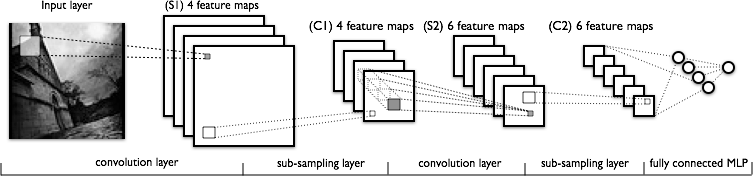

In [14]:
from IPython.display import Image
Image(filename=os.path.expanduser('~/Downloads/Mylenet.png'))

Importing the required libraries:

In [1]:
import os
import numpy as np
from pandas.io.parsers import read_csv
import cv2
import cPickle as pickle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet,BatchIterator
from lasagne.nonlinearities import softmax
import theano
import json as j

FTRAIN = '~/RightWhale/train.csv'
FTEST = '~/RightWhale/sample_submission.csv'
IMGPATH = '~/RightWhale/imgs/'
PATH = '~/RightWhale/'
SIZE = (96,96)

def float32(k):
    return np.cast['float32'](k)

Libraries for visualization:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

Function to load images as a numpy array:

In [3]:
def load_image( infilename ) :
    src=cv2.imread(os.path.expanduser(IMGPATH+infilename),cv2.CV_LOAD_IMAGE_GRAYSCALE)
    resized_image = cv2.resize(src, SIZE)
    return resized_image.flatten()

Functions to handle different load scenarios:

In [4]:
def load_new(test=False):
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe
    df = df.dropna()

    df['Image'] = df['Image'].apply(load_image)

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = 1.0*np.vstack(df['Image'].values) / 255  # scale pixel values to [0, 1]
    X = X.reshape(-1, 1, SIZE[0], SIZE[1])
    X = X.astype(np.float32)
    
    if test:
        return X
    else:
        y = df[df.columns[1:]].values
        y=y.astype(np.float32)
        return X, y

def load_rerun(test=False):
    if test:
        X1=pickle.load(open(os.path.expanduser(PATH+'X1.pickle'),'rb'))
        return X1
    else:
        X=pickle.load(open(os.path.expanduser(PATH+'X.pickle'),'rb'))
        y=pickle.load(open(os.path.expanduser(PATH+'y.pickle'),'rb'))
        return X,y
    
def load(rerun=False,test=False):
    if rerun:
        return load_rerun(test)
    else:
        return load_new(test)

Function to load already pickled neural net:

In [5]:
def load_net(fname='net.pickle'):
    return pickle.load(open(os.path.expanduser(PATH+fname),'rb'))

Function to save variables and the neural net as pickle dumps:

In [6]:
def save(net,X,y,X1):
    if net!=None:
        with open('net.pickle', 'wb') as f:
            pickle.dump(net, f, -1)
    
    if X!=None:
        with open('X.pickle', 'wb') as f:
            pickle.dump(X, f, -1)
    
    if y!=None:
        with open('y.pickle', 'wb') as f:
            pickle.dump(y, f, -1)
    
    if X1!=None:
        with open('X1.pickle', 'wb') as f:
            pickle.dump(X1, f, -1)

<p>FlipBatchIterator: Creates mirror images from X to supplement the training data. This helps prevent overfitting.</p>
<p>AdjustVariable: Adjusts a variable from the start value to the stop value.</p>

In [7]:
class FlipBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        return Xb, yb

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

These fuctions define the layers and the neural network:

In [8]:
def layersX(k=0,outn=433):
    layers0=[
            (layers.InputLayer, {'shape': (None, 1, SIZE[0], SIZE[1])}),
            (layers.Conv2DLayer,{'num_filters':32, 'filter_size':(3,3)}),
            (layers.MaxPool2DLayer,{'pool_size': (2,2)}),
            (layers.DropoutLayer,{'p':0.1}),
            (layers.Conv2DLayer,{'num_filters':64, 'filter_size':(2,2)}),
            (layers.MaxPool2DLayer,{'pool_size': (2,2)}),
            (layers.DropoutLayer,{'p':0.2}),
             (layers.Conv2DLayer,{'num_filters':128, 'filter_size':(2,2)}),
             (layers.MaxPool2DLayer,{'pool_size': (2,2)}),
             (layers.DropoutLayer,{'p':0.3}),
             (layers.DenseLayer,{'num_units': 1000}),
             (layers.DropoutLayer,{'p':0.5}),
            (layers.DenseLayer,{'num_units': 1000}),
            (layers.DenseLayer,{'num_units': outn, 'nonlinearity': softmax}),
            ]
    layers1=[
            (layers.InputLayer, {'shape': (None, 1, SIZE[0], SIZE[1])}),
            (layers.Conv2DLayer,{'num_filters':32, 'filter_size':(3,3)}),
        (layers.Conv2DLayer,{'num_filters':32, 'filter_size':(3,3)}),
        (layers.Conv2DLayer,{'num_filters':32, 'filter_size':(3,3)}),
        (layers.Conv2DLayer,{'num_filters':32, 'filter_size':(3,3)}),
            (layers.MaxPool2DLayer,{'pool_size': (2,2)}),
            (layers.DropoutLayer,{'p':0.1}),
            (layers.Conv2DLayer,{'num_filters':64, 'filter_size':(2,2)}),
        (layers.Conv2DLayer,{'num_filters':64, 'filter_size':(2,2)}),
        (layers.Conv2DLayer,{'num_filters':64, 'filter_size':(2,2)}),
            (layers.MaxPool2DLayer,{'pool_size': (2,2)}),
            (layers.DropoutLayer,{'p':0.2}),
             (layers.Conv2DLayer,{'num_filters':128, 'filter_size':(2,2)}),
        (layers.Conv2DLayer,{'num_filters':128, 'filter_size':(2,2)}),
        (layers.Conv2DLayer,{'num_filters':128, 'filter_size':(2,2)}),
             (layers.MaxPool2DLayer,{'pool_size': (2,2)}),
             (layers.DropoutLayer,{'p':0.3}),
             (layers.DenseLayer,{'num_units': 1000}),
             (layers.DropoutLayer,{'p':0.5}),
            (layers.DenseLayer,{'num_units': 1000}),
            (layers.DenseLayer,{'num_units': outn, 'nonlinearity': softmax}),
            ]
    if k==0:
        return layers0
    else:
        return layers1
        

def nnet(n,outn=433,k=0):
    net = NeuralNet(
        layers=layersX(k,outn),

        update_learning_rate=theano.shared(float32(0.04)),
        update_momentum=theano.shared(float32(0.9)),

        regression=True,
        batch_iterator_train=FlipBatchIterator(batch_size=128),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
            AdjustVariable('update_momentum', start=0.9, stop=0.999),
            ],
        max_epochs=n,
        verbose=1,
        )
    return net

These functions call the training and testing procedures.

In [9]:
def train(k=0,n=3000,rerun=False):
    if rerun:
        X,y=load(rerun=rerun)
    else:
        X,y=load()
    
    net=nnet(n=n,k=k).fit(X,y)
    save(net,X,y,None)
    return net

def test(outfile,rerun=False,netfile='net.pickle'):
    if rerun:
        X1=load(test=True,rerun=rerun)
    else:
        X1=load(test=True)
    net=load_net(netfile)
    KL=net.predict(X1)
    KL=(KL-np.amin(KL))/(np.amax(KL)-np.amin(KL))
    KL=KL.reshape(6925,433)
    np.savetxt(os.path.expanduser(PATH+outfile), KL, delimiter=',', newline='\n')
    return "Output file: "+PATH+outfile

In [10]:
train(n=2000,rerun=True,k=0)

# Neural Network with 16964905 learnable parameters

## Layer information

  #  name        size
---  ----------  ---------
  0  input0      1x96x96
  1  conv2d1     32x94x94
  2  maxpool2d2  32x47x47
  3  dropout3    32x47x47
  4  conv2d4     64x46x46
  5  maxpool2d5  64x23x23
  6  dropout6    64x23x23
  7  conv2d7     128x22x22
  8  maxpool2d8  128x11x11
  9  dropout9    128x11x11
 10  dense10     1000
 11  dropout11   1000
 12  dense12     1000
 13  dense13     433

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -------
      1       0.00230       0.00230      1.00001  628.74s
      2       0.00230       0.00230      1.00001  583.06s
      3       0.00230       0.00230      1.00001  620.88s


/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10961bf90>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x10a7e4090>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 96, 96)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': (3, 3), 'num_filters': 32}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'pool_size': (2, 2)}), (<class 'lasagne.layers.noise.DropoutLayer'>, {'p': 0.1})...e.layers.dense.DenseLayer'>, {'num_units': 433, 'nonlinearity': <function softmax at 0x109144230>})],
     loss=None, max_epochs=3, more_params={},
     objective=<function objective at 0x109629848>,
     objective_loss_function=<function squared_error at 0x10929fc80>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x10a84f0d0>, <__main__.AdjustVariable object at 0x10a84f110>, <nolearn.lasagne.handlers.PrintLog instance at 0x10a7b7a

In [25]:
test('Result.csv',rerun=True)

'Output file: ~/RightWhale/Result.csv'

<h2>Visualizing the Layers</h2>

In [ ]:
net=load_net(netfile='net.pickle')

<module 'matplotlib.pyplot' from '/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/matplotlib-1.5.0+669.g1fe4df7-py2.7-macosx-10.5-x86_64.egg/matplotlib/pyplot.pyc'>

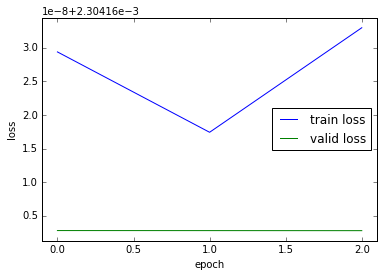

In [27]:
plot_loss(net)

<module 'matplotlib.pyplot' from '/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/matplotlib-1.5.0+669.g1fe4df7-py2.7-macosx-10.5-x86_64.egg/matplotlib/pyplot.pyc'>

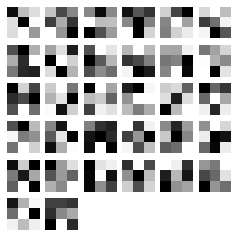

In [28]:
plot_conv_weights(net.layers_[1], figsize=(4, 4))

<module 'matplotlib.pyplot' from '/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/matplotlib-1.5.0+669.g1fe4df7-py2.7-macosx-10.5-x86_64.egg/matplotlib/pyplot.pyc'>

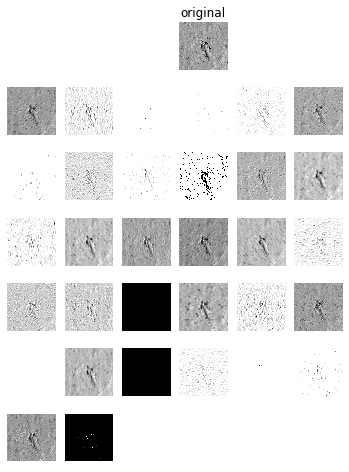

In [29]:
plot_conv_activity(net.layers_[1], X1[0:1])

<module 'matplotlib.pyplot' from '/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/matplotlib-1.5.0+669.g1fe4df7-py2.7-macosx-10.5-x86_64.egg/matplotlib/pyplot.pyc'>

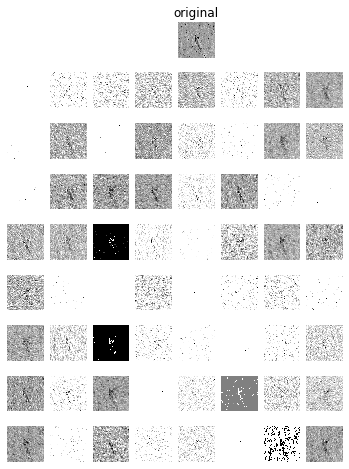

In [32]:
plot_conv_activity(net.layers_[4], X1[0:1])

<module 'matplotlib.pyplot' from '/Users/rajkirangaddati/anaconda/lib/python2.7/site-packages/matplotlib-1.5.0+669.g1fe4df7-py2.7-macosx-10.5-x86_64.egg/matplotlib/pyplot.pyc'>

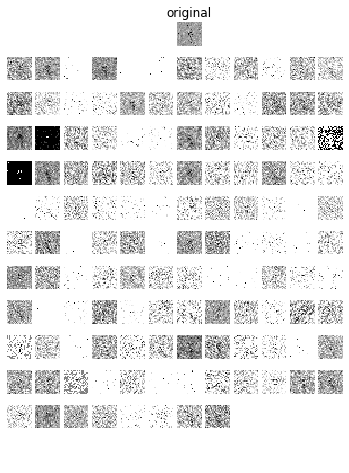

In [33]:
plot_conv_activity(net.layers_[7], X1[0:1])